In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad

In [2]:
sc.settings.verbosity = 3            
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.2 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.0 python-igraph==0.9.8 pynndescent==0.5.5


In [3]:
# reading data

# biospsy tissue samples, endometrium
adata_ti = sc.read_h5ad(
            "/home/vfs/PycharmProjects/Organoids_sc_WS2122/data/Garcia_Alonso_tissue/GarciaAlsonso_tissue_subsampled.h5ad")

In [5]:
# unique feature names
adata_ti.var_names_make_unique()
# normalize
sc.pp.normalize_total(adata_ti, target_sum=1e4)
# logarithmize
sc.pp.log1p(adata_ti)

normalizing counts per cell
    finished (0:00:00)


In [3]:
# endometrial organoids, 1 donor 

adata_org = sc.read_h5ad(
            "/home/vfs/PycharmProjects/Organoids_sc_WS2122/data/Garcia_Alonso_tissue/GarciaAlsonso_organoid_subsampled.h5ad"
)

In [4]:
# unique feature names
adata_org.var_names_make_unique()
# normalize
sc.pp.normalize_total(adata_org, target_sum=1e4)
# logarithmize
sc.pp.log1p(adata_org)

normalizing counts per cell
    finished (0:00:00)


## Objective: Do endometerial organoid cell types resemble the tissue cell types? 

## Analysis steps:  
### Tissue
* sample clustering and check for merge possibility 
    - PCA plot
    - UMAP (all samples, sample wise coloring)
    - UMAP after samples -> check if mergeable
* merge samples
    - UMAP for confirmation again
* subsample for epithila cell types bc those are the once we expect in organoids too
* cluster/UMAP again

### Organoids 
* sample clustering and check for merge possibility 
    - PCA plot
    - UMAP (all samples, sample wise coloring)
    - UMAP after samples -> check if mergeable
* merge samples
    - UMAP for confirmation again

## Downstream analysis: 
* plot with proportion number of cells per cell type (?)
* correlation between increase of certain cell type in tissue and organoids

### Tissue: sample clustering and check for merge possibility

In [16]:
# PCA 
sc.tl.pca(adata_ti, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_ti, log=True)

computing PCA
    with n_comps=50


KeyboardInterrupt: 

The ellbow starts to flatten with 31 PCs. One could calculate more. However, the comparabily low detail of the celltype
labeling indicates that this is not necessary.

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:57)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


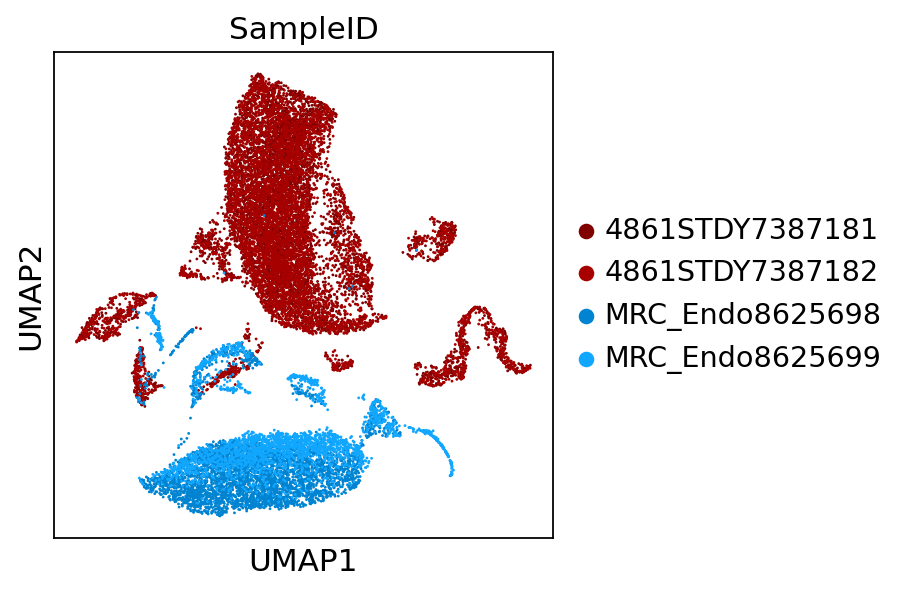

In [17]:
# UMAP all samples

sc.pp.neighbors(adata_ti, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata_ti)

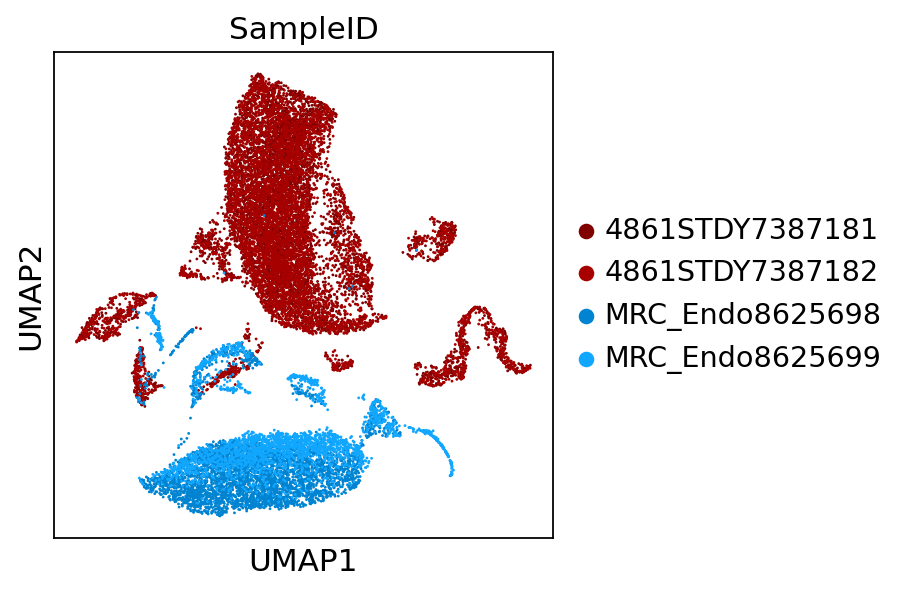

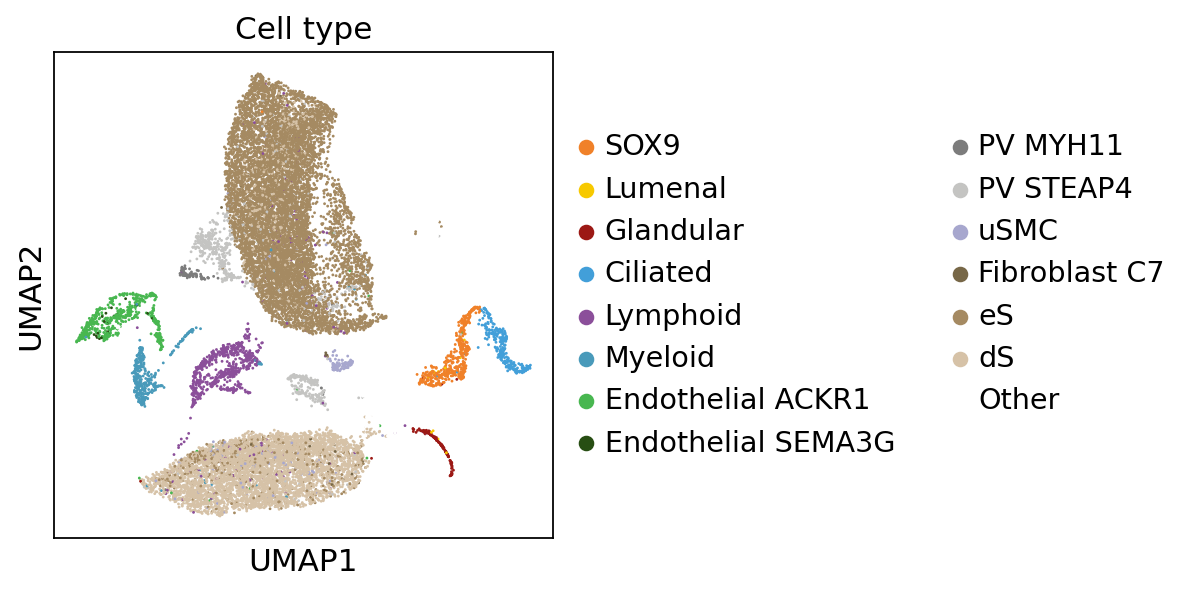

In [18]:
sc.pl.umap(adata_ti, color="SampleID")
sc.pl.umap(adata_ti, color="Cell type")


Those UMAPs indicate that the two samples from each state could be merged together. (Why? elaborate)

In [20]:
# enabel sample wise analysis
adata_ti_pro_1 = adata_ti[adata_ti.obs["SampleID"] == "4861STDY7387181", :]  #pro sample 1
adata_ti_pro_2 = adata_ti[adata_ti.obs["SampleID"] == "4861STDY7387182", :]  #pro sample 2
adata_ti_sec_1 = adata_ti[adata_ti.obs["SampleID"] == "MRC_Endo8625698", :]  #sec sample 1
adata_ti_sec_2 = adata_ti[adata_ti.obs["SampleID"] == "MRC_Endo8625699", :]  #sec sample 2

# merging both proliferating phase sample, and both secretory stage samples
adata_ti_merged_proliferative = ad.concat([adata_ti_pro_1,adata_ti_pro_2], join="outer")
adata_ti_merged_secretory = ad.concat([adata_ti_sec_1,adata_ti_sec_2], join="outer")

data_list_merged_ti = [adata_ti_merged_proliferative, adata_ti_merged_secretory]

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


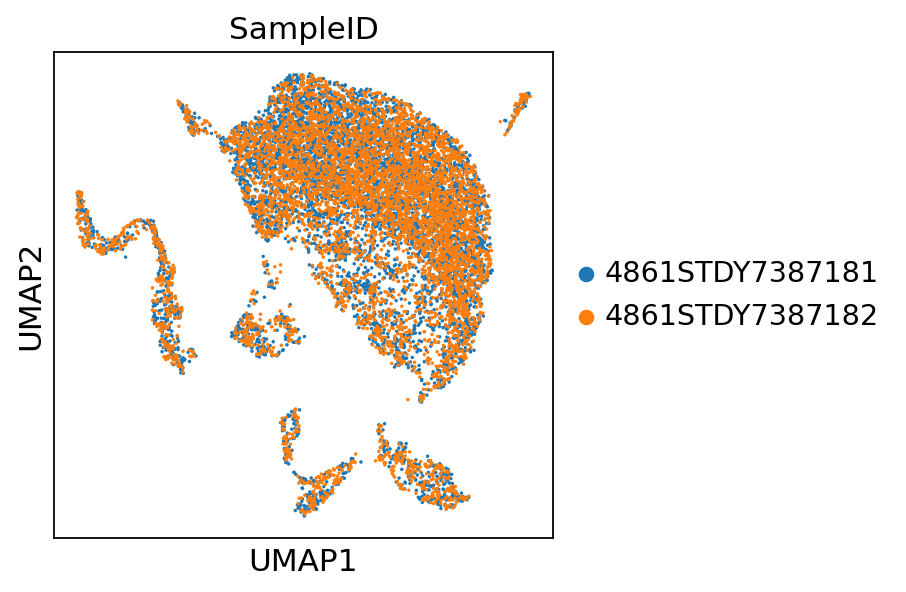

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


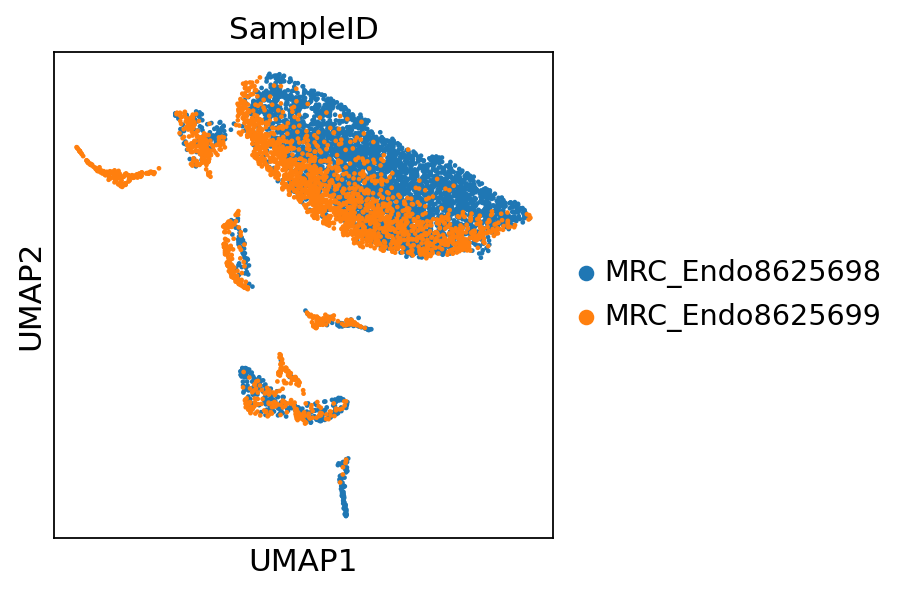

In [23]:
# UMAP per men.cycle stage
for item in data_list_merged_ti:
    sc.pp.neighbors(item, n_neighbors=10, n_pcs=30)
    sc.tl.umap(item)

In [ ]:
for item in data_list_merged_ti:
    sc.pl.umap(item, color="SampleID")

the two samples cluster together very good. No data integration is needed.

Now we check for cell types similarities between the phases

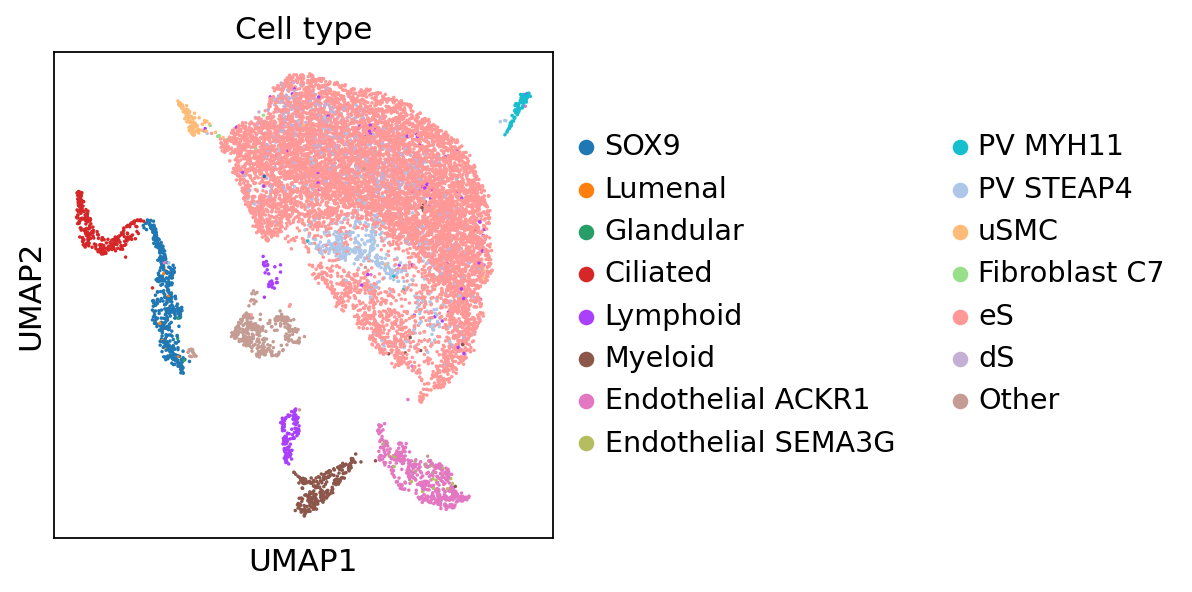

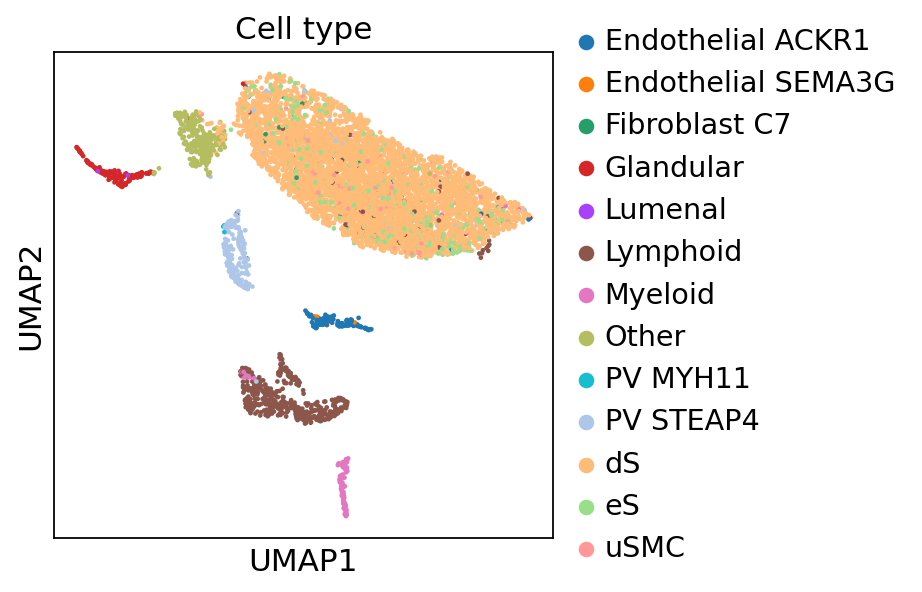

In [25]:
# UMAP for cell types
for item in data_list_merged_ti:
    sc.pl.umap(item, color="Cell type") # TODO force color on cell type, for comparability of both plots

Since in organoids we will only expect epithelia cell types we subsample the tissue samples for epithila cell types
only too. Taken from [the paper](link to mapping paper) the epithelia cell types are:  Lumen, Gland, SOX9,

In [26]:
adata_ti.obs

SampleID  log2p1_count  percent_mito  \
4861STDY7387181_AAACCTGAGGCATGGT  4861STDY7387181     13.951467      0.057320   
4861STDY7387181_AAACCTGAGGGCACTA  4861STDY7387181     13.776227      0.043838   
4861STDY7387181_AAACCTGAGTGAAGTT  4861STDY7387181     12.894628      0.070791   
4861STDY7387181_AAACCTGAGTGGGCTA  4861STDY7387181     12.329235      0.071137   
4861STDY7387181_AAACCTGCACCGAAAG  4861STDY7387181     12.171176      0.063977   
...                                           ...           ...           ...   
MRC_Endo8625699_TTTGGAGGTAACGATA  MRC_Endo8625699     12.696532      0.005876   
MRC_Endo8625699_TTTGGTTAGATACCAA  MRC_Endo8625699     13.761448      0.092179   
MRC_Endo8625699_TTTGGTTAGCATATGA  MRC_Endo8625699     14.286557      0.074063   
MRC_Endo8625699_TTTGGTTAGTATGGAT  MRC_Endo8625699     13.192447      0.133440   
MRC_Endo8625699_TTTGTTGCACACCGAC  MRC_Endo8625699     13.750288      0.088758   

                                  n_genes DonorID          BiopsyType  \
4861STDY7387181_AAACCTGAGGCATGGT     3842     A13         Organ_Donor   
4861STDY7387181_AAACCTGAGGGCACTA     3544     A13         Organ_Donor   
4861STDY7387181_AAACCTGAGTGAAGTT     2507     A13         Organ_Donor   
4861STDY7387181_AAACCTGAGTGGGCTA     1928     A13         Organ_Donor   
4861STDY7387181_AAACCTGCACCGAAAG     1824     A13         Organ_Donor   
...                                   ...     ...                 ...   
MRC_Endo8625699_TTTGGAGGTAACGATA     1784      E1  Superficial_Biopsy   
MRC_Endo8625699_TTTGGTTAGATACCAA     3166      E1  Superficial_Biopsy   
MRC_Endo8625699_TTTGGTTAGCATATGA     4024      E1  Superficial_Biopsy   
MRC_Endo8625699_TTTGGTTAGTATGGAT     2809      E1  Superficial_Biopsy   
MRC_Endo8625699_TTTGTTGCACACCGAC     3352      E1  Superficial_Biopsy   

                                              Location   Binary Stage  \
4861STDY7387181_AAACCTGAGGCATGGT  endometrium_enriched  Proliferative   
4861STDY7387181_AAACCTGAGGGCACTA  endometrium_enriched  Proliferative   
4861STDY7387181_AAACCTGAGTGAAGTT  endometrium_enriched  Proliferative   
4861STDY7387181_AAACCTGAGTGGGCTA  endometrium_enriched  Proliferative   
4861STDY7387181_AAACCTGCACCGAAAG  endometrium_enriched  Proliferative   
...                                                ...            ...   
MRC_Endo8625699_TTTGGAGGTAACGATA    endometrium_biopsy      Secretory   
MRC_Endo8625699_TTTGGTTAGATACCAA    endometrium_biopsy      Secretory   
MRC_Endo8625699_TTTGGTTAGCATATGA    endometrium_biopsy      Secretory   
MRC_Endo8625699_TTTGGTTAGTATGGAT    endometrium_biopsy      Secretory   
MRC_Endo8625699_TTTGTTGCACACCGAC    endometrium_biopsy      Secretory   

                                           Stage Broad cell type  Cell type  \
4861STDY7387181_AAACCTGAGGCATGGT   proliferative         Stromal         eS   
4861STDY7387181_AAACCTGAGGGCACTA   proliferative         Stromal         eS   
4861STDY7387181_AAACCTGAGTGAAGTT   proliferative      Supporting  PV STEAP4   
4861STDY7387181_AAACCTGAGTGGGCTA   proliferative         Stromal         dS   
4861STDY7387181_AAACCTGCACCGAAAG   proliferative         Stromal         eS   
...                                          ...             ...        ...   
MRC_Endo8625699_TTTGGAGGTAACGATA  late-secretory        Excluded      Other   
MRC_Endo8625699_TTTGGTTAGATACCAA  late-secretory         Stromal         dS   
MRC_Endo8625699_TTTGGTTAGCATATGA  late-secretory         Stromal         dS   
MRC_Endo8625699_TTTGGTTAGTATGGAT  late-secretory         Stromal         eS   
MRC_Endo8625699_TTTGTTGCACACCGAC  late-secretory      Supporting       uSMC   

                                 CellCycle Phase  
4861STDY7387181_AAACCTGAGGCATGGT               S  
4861STDY7387181_AAACCTGAGGGCACTA              G1  
4861STDY7387181_AAACCTGAGTGAAGTT              G1  
4861STDY7387181_AAACCTGAGTGGGCTA              G1  
4861STDY7387181_AAACCTGCACCGAAAG              G1  
...                                          ...  
MRC_Endo

In [ ]:
# subsampling tissue for epithelia cells

adata_ti


In order to get a feeling if the amount of cells of certain cell types have changed across the cycle we analysed
proportional changes of cell counts per cell type between both states.

1. get total cell number per sample (tissue-prolif, tissue-secre, organoid-cntlr, organoid-E2 treated)
2. get cell number per cell type
3. get proportion per cell type
4. indicate increase or decrease over time

In [30]:
adata_org_cntrl_0 = adata_org[adata_org.obs["sample_names"] == "WSSS_END9397520",:] # cntrl, day0

adata_org_cntrl_0.obs.columns
list = adata_org_cntrl_0.obs["Celltype_without_inhibitors"].cat.categories.tolist()
print(list)
type(list)
type(adata_org_cntrl_0)

['NH_Day0', 'NH_Proliferative', 'NH_Day2', 'NH_Day6', 'Pre-ciliated', 'Ciliated', 'Secretory', 'Inflamatory']


anndata._core.anndata.AnnData

In [ ]:
adata_org_merged_cntrl = ad.concat([adata_org_cntrl_0, 
                                   adata_org_cntrl_2, 
                                   adata_org_cntrl_6], join="inner")

In [ ]:

adata_org_merged_cntrl.obs["Celltype_without_inhibitors"].batch

In [19]:
# some pandas magic to get the required numbers and values 
cell_counts_per_sample = []

for item in data_list_merged_ti:
    cell_counts_per_sample.append() = len(item)

    # get list of cell types
    celltypes = item.obs["Celltype_without_inhibitors"].cat.categories.tolist()

SyntaxError: cannot assign to function call (1019819766.py, line 5)

computing PCA
    with n_comps=50
    finished (0:01:15)


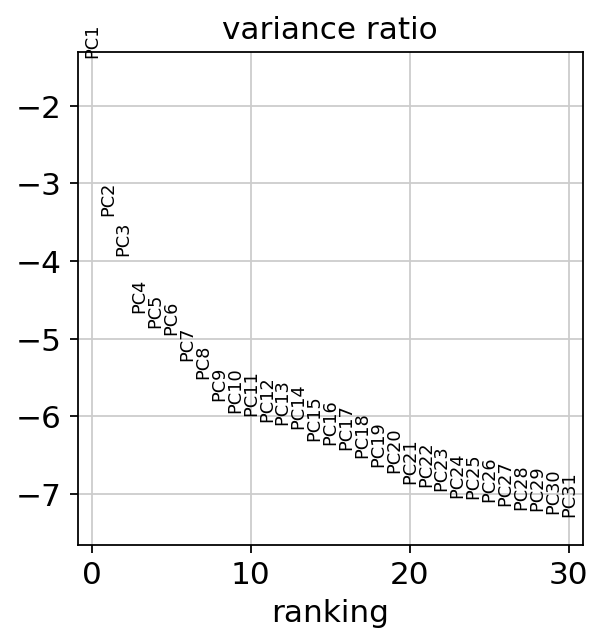

In [4]:
# PCA 
sc.tl.pca(adata_org, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_org, log=True)

same as for tissue: The ellbow starts to flatten with 31 PCs. One could calculate more. However, the comparabily low detail of the celltype labeling indicates that this is not necessary.

In [5]:
# UMAP all samples

sc.pp.neighbors(adata_org, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata_org)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


In [8]:
adata_org.obs

demultiplexed     sample_names  log2p1_count  \
WSSS_END9397520_AAACCCAAGTAGGAAG            U2  WSSS_END9397520     13.902563   
WSSS_END9397520_AAACCCACACAAGCTT            U2  WSSS_END9397520     13.438143   
WSSS_END9397520_AAACCCACACATGTTG            U1  WSSS_END9397520     13.585785   
WSSS_END9397520_AAACCCACACTCAAGT            U1  WSSS_END9397520     12.751125   
WSSS_END9397520_AAACCCAGTCGCACAC            U1  WSSS_END9397520     13.382354   
...                                        ...              ...           ...   
WSSS_END9397533_TTTGTTGCACAGCCAC            U2  WSSS_END9397533     12.576013   
WSSS_END9397533_TTTGTTGCAGGTTCAT           B44  WSSS_END9397533     13.092262   
WSSS_END9397533_TTTGTTGCAGTAGAAT           B44  WSSS_END9397533     13.100990   
WSSS_END9397533_TTTGTTGTCCATAAGC            U2  WSSS_END9397533     11.893681   
WSSS_END9397533_TTTGTTGTCTCGCTCA            U2  WSSS_END9397533     12.091435   

                                  percent_mito  n_genes Days Hormones  \
WSSS_END9397520_AAACCCAAGTAGGAAG      0.131979     3837    0     Ctrl   
WSSS_END9397520_AAACCCACACAAGCTT      0.086592     3261    0     Ctrl   
WSSS_END9397520_AAACCCACACATGTTG      0.124614     3421    0     Ctrl   
WSSS_END9397520_AAACCCACACTCAAGT      0.095314     2488    0     Ctrl   
WSSS_END9397520_AAACCCAGTCGCACAC      0.127189     3137    0     Ctrl   
...                                        ...      ...  ...      ...   
WSSS_END9397533_TTTGTTGCACAGCCAC      0.161835     1717    6      E+P   
WSSS_END9397533_TTTGTTGCAGGTTCAT      0.077760     2635    6      E+P   
WSSS_END9397533_TTTGTTGCAGTAGAAT      0.110871     2759    6      E+P   
WSSS_END9397533_TTTGTTGTCCATAAGC      0.082808     1205    6      E+P   
WSSS_END9397533_TTTGTTGTCTCGCTCA      0.107724     1331    6      E+P   

                                 Inhibitor  IsClonal  \
WSSS_END9397520_AAACCCAAGTAGGAAG      Ctrl     False   
WSSS_END9397520_AAACCCACACAAGCTT      Ctrl     False   
WSSS_END9397520_AAACCCACACATGTTG      Ctrl     False   
WSSS_END9397520_AAACCCACACTCAAGT      Ctrl     False   
WSSS_END9397520_AAACCCAGTCGCACAC      Ctrl     False   
...                                    ...       ...   
WSSS_END9397533_TTTGTTGCACAGCCAC      Ctrl     False   
WSSS_END9397533_TTTGTTGCAGGTTCAT      Ctrl     False   
WSSS_END9397533_TTTGTTGCAGTAGAAT      Ctrl     False   
WSSS_END9397533_TTTGTTGTCCATAAGC      Ctrl     False   
WSSS_END9397533_TTTGTTGTCTCGCTCA      Ctrl     False   

                                 Celltype_without_inhibitors        Celltype  \
WSSS_END9397520_AAACCCAAGTAGGAAG                     NH_Day0           NH_d0   
WSSS_END9397520_AAACCCACACAAGCTT                     NH_Day0           NH_d0   
WSSS_END9397520_AAACCCACACATGTTG                     NH_Day0           NH_d0   
WSSS_END9397520_AAACCCACACTCAAGT                     NH_Day0           NH_d0   
WSSS_END9397520_AAACCCAGTCGCACAC                     NH_Day0           NH_d0   
...                                                      ...             ...   
WSSS_END9397533_TTTGTTGCACAGCCAC                   Secretory  Secretory_Ctrl   
WSSS_END9397533_TTTGTTGCAGGTTCAT                   Secretory  Secretory_Ctrl   
WSSS_END9397533_TTTGTTGCAGTAGAAT                    Ciliated        Ciliated   
WSSS_END9397533_TTTGTTGTCCATAAGC                   Secretory  Secretory_Ctrl   
WSSS_END9397533_TTTGTTGTCTCGCTCA                   Secretory  Secretory_Ctrl   

                                 CellCycle Phase  
WSSS_END9397520_AAACCCAAGTAGGAAG             G2M  
WSSS_END9397520_AAACCCACACAAGCTT             G2M  
WSSS_END9397520_AAACCCACACATGTTG              G1  
WSSS_END9397520_AAACCCACACTCAAGT              G1  
WSSS_END9397520_AAACCCAGTCGCACAC              G1  
...                                          ...  
WSSS_END9397533_TTTGTTGCACAGCCAC              G1  
WSSS_END9397533_TTTGTTGCAGGTTCAT              G1  
WSSS_END9397533_TTTGTTGCAGTAGAAT              G1  
WSSS_END9397533_TTTGTTGTCCATAAGC       

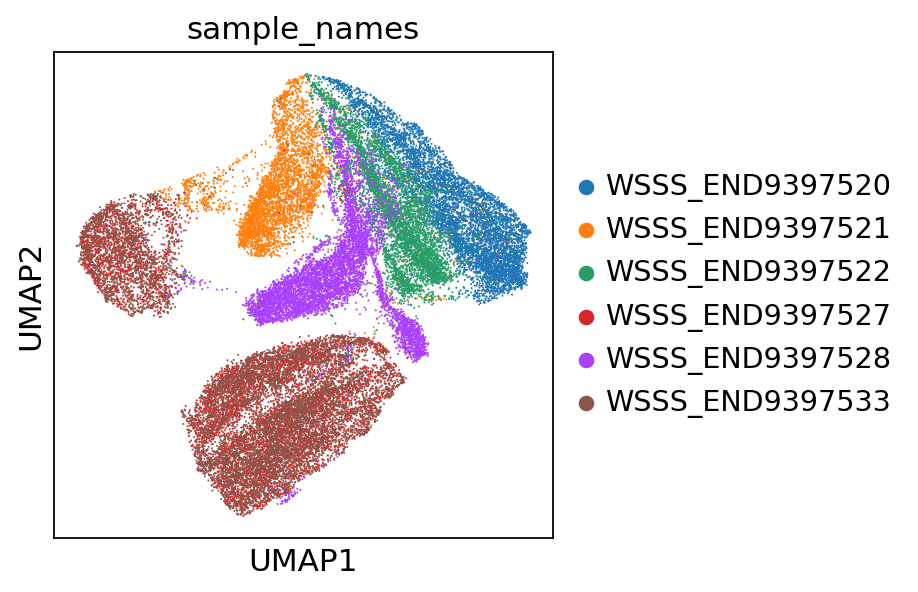

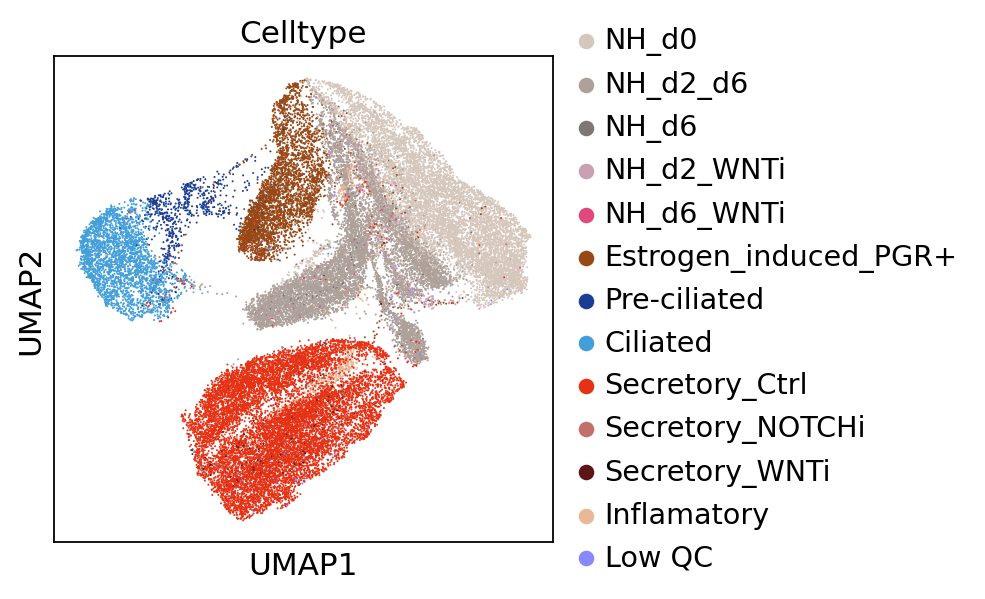

In [9]:
sc.pl.umap(adata_org, color="sample_names")
sc.pl.umap(adata_org, color="Celltype")

Those UMAPs indicate that there is a clear distiction between the three organoid groups:  
* untreated  
* treated with E2 only  
* treated with both E2 and P4  

Therefore samples for those three groups are getting merged. 

In [5]:
# controls
adata_org_cntrl_0 = adata_org[adata_org.obs["sample_names"] == "WSSS_END9397520",:] # cntrl, day0
adata_org_cntrl_2 = adata_org[adata_org.obs["sample_names"] == "WSSS_END9397522",:] #or sample 2 # day 6, comp: XAV939, no stim
adata_org_cntrl_6 = adata_org[adata_org.obs["sample_names"] == "WSSS_END9397528",:] #or sample 3 # day 6, no stim, no compound
# merging controls
adata_org_merged_cntrl = ad.concat([adata_org_cntrl_0, 
                                   adata_org_cntrl_2, 
                                   adata_org_cntrl_6], join="outer" )

# estrogen treated
adata_org_tx_E2_0 = adata_org[adata_org.obs["sample_names"] == "WSSS_END9397521",:] # E2, day 0

# estrogen and progesteron treated 
adata_org_tx_E2P4_2 = adata_org[adata_org.obs["sample_names"] == "WSSS_END9397527",:] # E2 + P4 day 2
adata_org_tx_E2P4_6 = adata_org[adata_org.obs["sample_names"] == "WSSS_END9397533",:] # E2 + P4, day 6
# merging E2P4 treated
adata_org_merged_E2P4 = ad.concat([adata_org_tx_E2P4_2, 
                                  adata_org_tx_E2P4_6], join="outer")

data_list_org_groups = [adata_org_merged_cntrl, 
                       adata_org_tx_E2_0,
                       adata_org_merged_E2P4]

In [6]:
adata_org_merged_cntrl = ad.concat([adata_org_cntrl_0, 
                                   adata_org_cntrl_2, 
                                   adata_org_cntrl_6], join="outer" )

# adata_org_merged_cntrl.obs["sample_names"].cat.categories

In [21]:
# calculated UMAPs
for item in data_list_org_groups:
    sc.pp.neighbors(item, n_neighbors=10, n_pcs=30)
    sc.tl.umap(item)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample_names' as categorical
/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Celltype_without_inhibitors' as categorical
/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` paramete

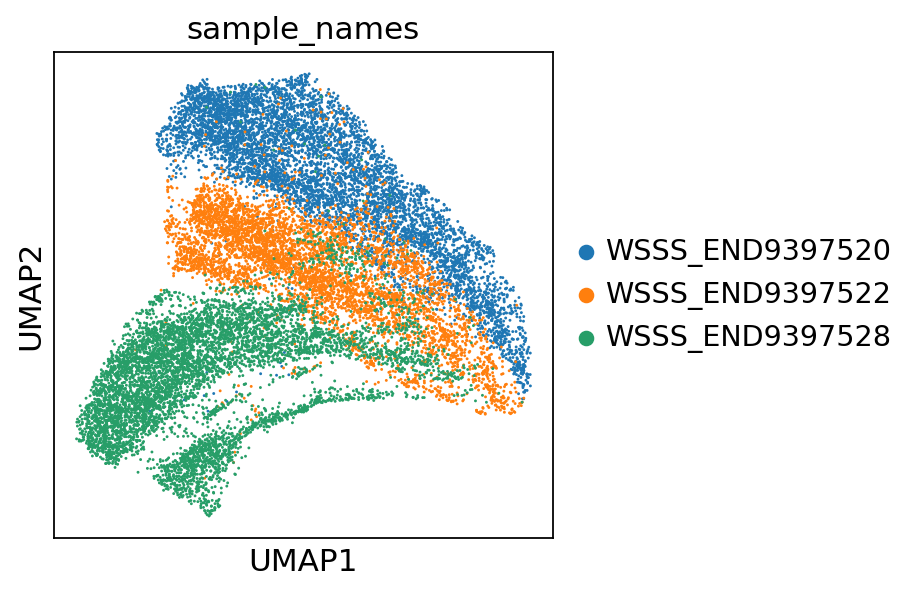

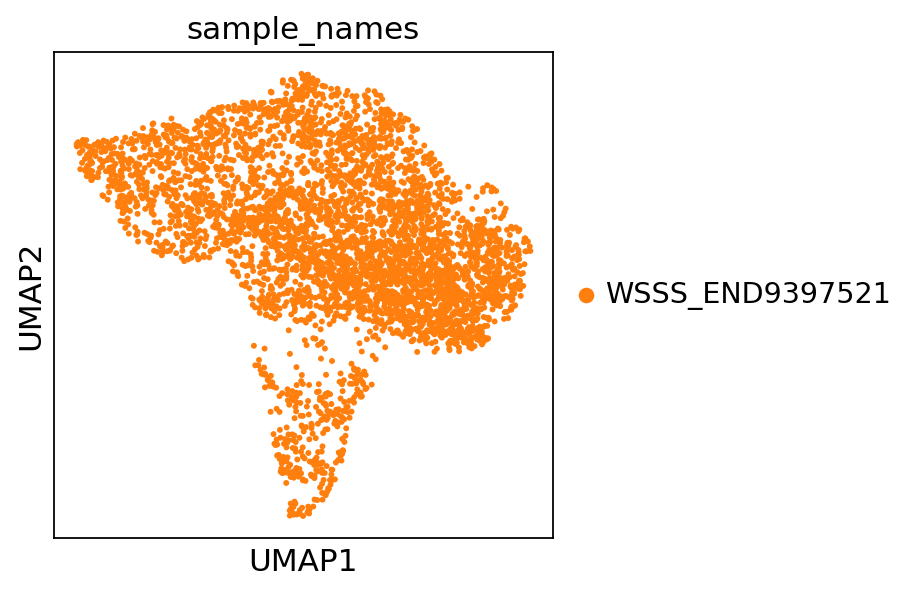

/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample_names' as categorical
/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Celltype_without_inhibitors' as categorical
/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` paramete

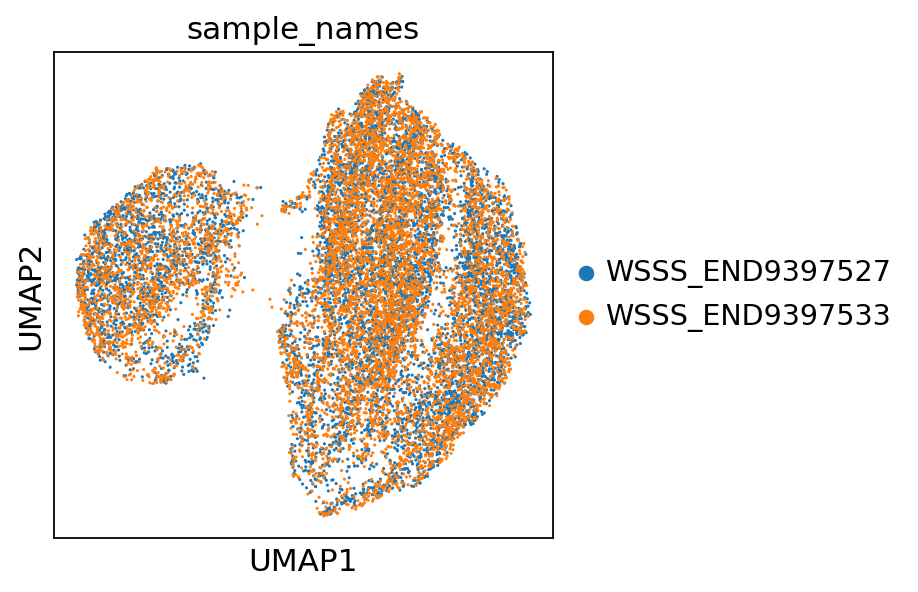

In [22]:
for item in data_list_org_groups:
    sc.pl.umap(item, color="sample_names")

!! Statement over merging decision needed !! 

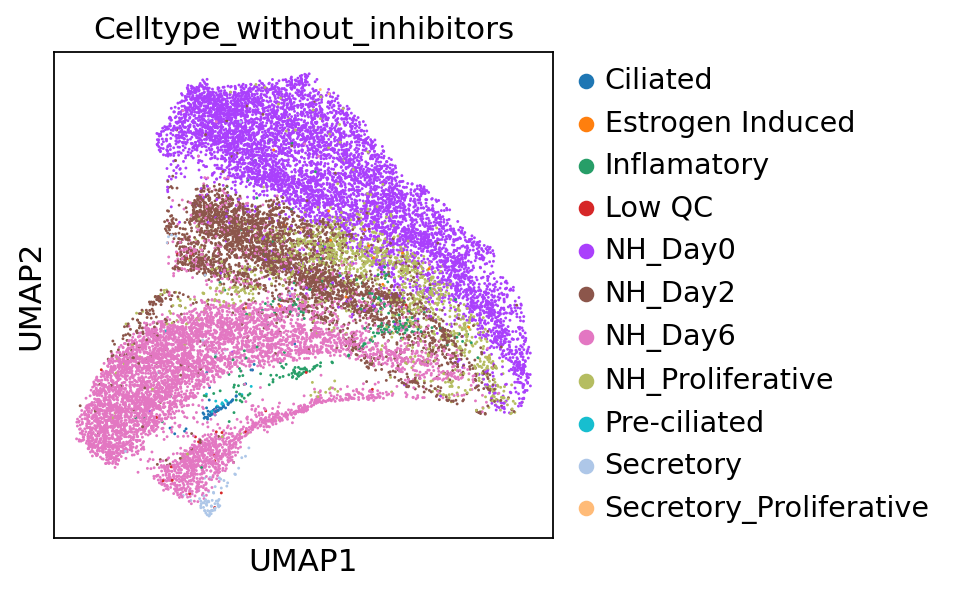

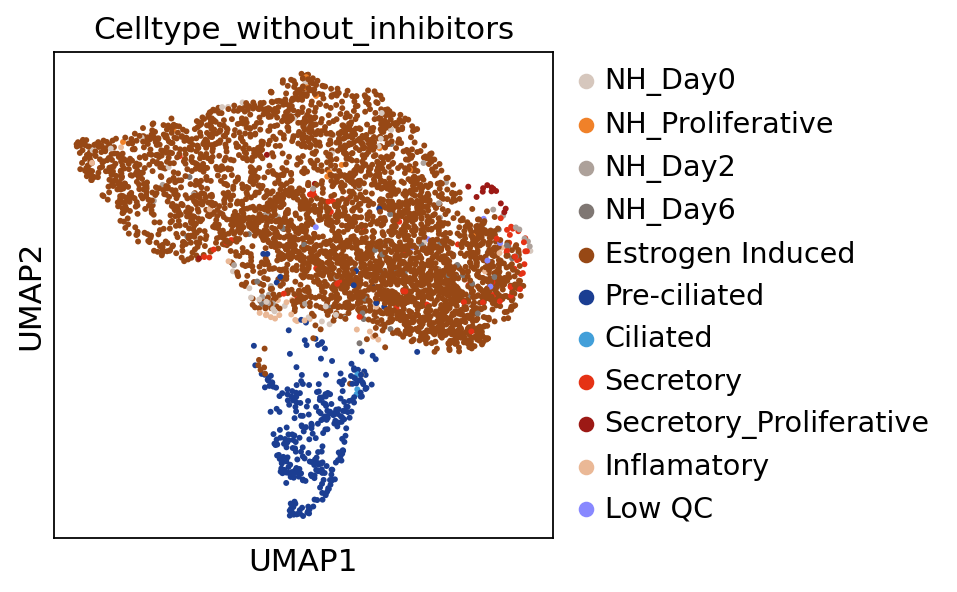

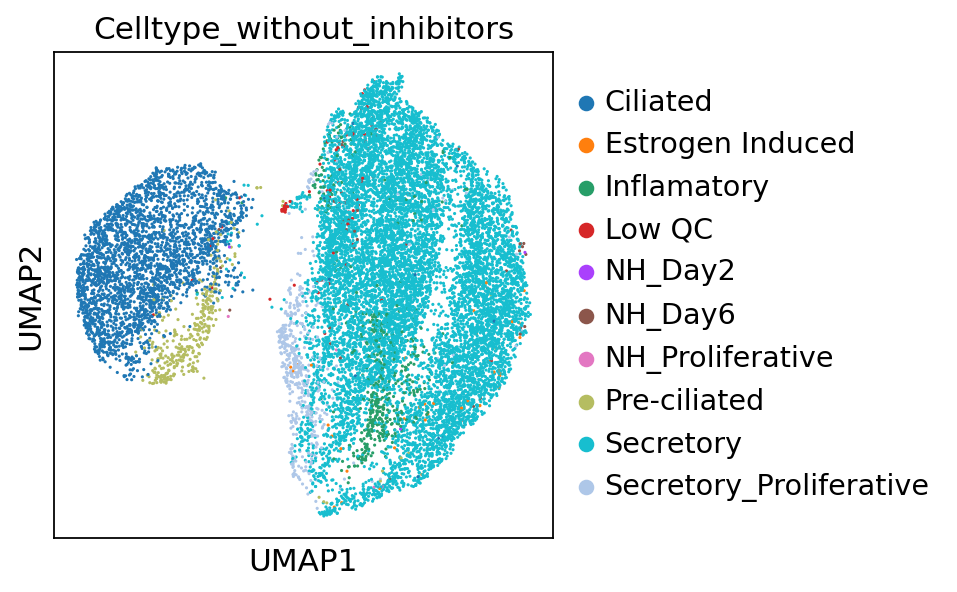

In [26]:
# UMAP for cell types
for item in data_list_org_groups:
    sc.pl.umap(item, color="Celltype_without_inhibitors")  # TODO force color on cell type, for comparability of both plots

In order to get a feeling if the amount of cells of certain cell types have changed across the cycle we analysed
proportional changes of cell counts per cell type between both states.
1. get total cell number per sample (tissue-prolif, tissue-secre, organoid-cntlr, organoid-E2 treated)
2. get cell number per cell type
3. get proportion per cell type
4. indicate increase or decrease over time

## Comparision of propotional development of celltypes due to hormone influence in tissue and organoids

In [24]:
# WIP 

## Objective: Does the cycle state of the donor influence the organoid?

### Analysis steps: 
* looking for gene marker specific for proliferative phase (endothelia cells only)
    - Table with differentially expressed genes in tissue
* check for cycle-state specificity
    - heatmap comparing proliferative tissue & secretory tissue
    - heatmap scaled and normalized
* check for transferablilty to organoids (Day0  and Day6)
    - heatmap with prolif, secretory tissue + day0, day6 organoids
    - saled and normalized 

### Differential gene expression organoids 

In [8]:
for item in data_list_org_groups:    
    sc.tl.rank_genes_groups(item, 'Celltype_without_inhibitors', method='wilcoxon') 
    # TODO: it throws warings about not beeing logarithmized, idk where those come from, needs to be investigated further

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:32)
ranking genes


/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:22)


In [9]:
for item in data_list_org_groups:
    #show the 10 top ranked genes per cluster in a dataframe:
    print(pd.DataFrame(item.uns['rank_genes_groups']['names']).head(10))

   Ciliated Estrogen Induced Inflamatory  Low QC NH_Day0 NH_Day2  NH_Day6  \
0     TPPP3            UQCC2       KRT23    MT1E  RPL13A    NACA       CP   
1  C20orf85           MT-ND6     S100A11    MT1H    MMP7  MT-CO3     TFF3   
2     ODF3B            PRDX1       ITGB8    MT1G  NAP1L1  MT-ND1     SLPI   
3   C5orf49           NDUFS5       ANXA2    MT2A   RPL23    RPL3     IGF2   
4   FAM183A            NR2F2       KRT19    MT1X   RPS20   PPDPF     AGR3   
5      CAPS           SNRPD1        IL32    MT1M   RPS17   ITM2C    MUC5B   
6    IGFBP7           TUBA1B       MUC16    MT1F   RPS11   RPL15     LCN2   
7     RSPH1            NUDT1     TACSTD2    TFF3   FBLN1   RPL19  SLC40A1   
8   C9orf24            CPSF6    SH3BGRL3    BST2   COTL1    CYBA  SLC34A2   
9     SMIM6            PSMA7   RAB11FIP1  S100A6    RPSA    RPS7    WFDC2   

  NH_Proliferative Pre-ciliated Secretory Secretory_Proliferative  
0            HMGB2      C5orf49      TFF3                   UBE2C  
1         KIAA01